In [1]:
import numpy as np
import math
import os
import traceback
from scipy import signal
from scipy import optimize
# import UDIP_4_Lib_V2 as UDIP_Lib_3  #making updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import matplotlib.pyplot as plt
from RockSat_json import *

# Flight Data Analysis

In [2]:
year = 2024
sourceName = 'UDIP123.dat'
#packets = import_data(f'../{year}/{year}_packet.json')
#packets = import_data(f'{year}_packet_FMS_1.json')
packets = import_data('UDIP_4.json')

In [3]:
print(sourceName)
print()
SensNum = len(packets['packets']['Sensor'])
print(f'There are {SensNum} Sensor packets')
print()
LinSweepNum = len(packets['packets']['Full'])
print(f'There are {LinSweepNum} Linear Sweeps')
print()
DensSweepNum = len(packets['packets']['Dense'])
print(f'There are {DensSweepNum} Dense Sweeps')

UDIP123.dat

There are 646799 Sensor packets

There are 903 Linear Sweeps

There are 101 Dense Sweeps


## Fitting Functions

In [3]:
def data_processing(V, I):
    #Imax = np.argmax(I) #find index of maximum Current
    Imax = max(I)  # Find the maximum current value
    #print(f'Imax = {Imax}')
    #Imin = np.argmin(I) #find index of minimum Current
    Imin = min(I)  # Find the minimum current value
    #print(f'Imin = {Imin}')

    V_proc = []
    I_proc = []
    for i in range(0,len(V)):
        #if ((V[i] > -0.8) & (V[i] < 0.5)):
        if((I[i] > (Imin + 9e-10)) & (I[i] < (Imax - 9e-10))):
            V_proc.append(V[i])
            I_proc.append(I[i])
    
    return V_proc, I_proc

In [4]:
def slope_fit(V_arr, I_arr, adcNum):
    
    V_proc, I_proc = V_arr, I_arr
    
    if(adcNum == 0):
        guess = [-1e-7, 6.3e-7]    #intial guess (m, b)
        #b = ((-np.inf, -24937.5e-9),(np.inf, 22062.5e-9)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
    elif(adcNum == 1):
        guess = [-1e-7, 6.5e-7]    #intial guess (m, b)
        #b = ((-np.inf, -1234.1e-9),(np.inf, 1050.6e-9)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
    elif(adcNum == 2):
        guess = [-1e-7, 5.8e-8]    #intial guess (m, b)
        #b = ((-np.inf, -50.03e-9),(np.inf, 58.8e-9)) #bounds
        #b = ((-np.inf, -58.8e-9),(np.inf, 50.03e-9)) #bounds
        #b = ((-np.inf, -5.8e-8),(np.inf, 5.8e-8)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
        V_proc, I_proc = data_processing(V_arr, I_arr)

    popt, pcov = optimize.curve_fit(model, V_proc, I_proc, guess, bounds = b)
    
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov


def model(V, m1, b):
    return lin_fit(V, m1, b)


def lin_fit(x, m, y_int): # linear fit
    return m * x + y_int

adc0_min = -24937.5e-9  # Amps
adc0_max = 22062.5e-9

acd1_min = -1234.1e-9
adc1_max = 1050.6e-9

adc2_min = -58.8e-9
adc2_max = 50.03e-9


## Sensor Packets

In [5]:
sensorNum = 10000
Sensor = packets['packets']['Sensor'][f'{sensorNum}']

print(Sensor)

{'Start': 3806983, 'Stop': 3806990, 'Count': 34464, 'Acceleration': [4.222990673792308, 3.866708582206853, -0.5972964476579692, [65535]], 'Spin Rate': [0.029906542056074768, 0.002136181575433912, 0.05126835781041388], 'Magnetic Field': [18.9404296875, -32.0361328125, -17.39013671875], 'Temperature': [32.520146520146525], 'Photo Diode': [0.06698717948717949]}


In [4]:
sensor = packets['packets']['Sensor']
print(len(sensor))
# for i in range(0, len(sensor)):
#     accel = sensor[f'{i}']['Acceleration']
#     print(f'acceleration {i}: {accel}')

646799


In [20]:
sensor = packets['packets']['Sensor']

accX = []
accY = []
accZ = []

accRawX = []
accRawY = []
accRawZ = []


time = []

#for i in range (0, len(sensor)):
for i in range (0, 15000):
    accX.append(sensor[f'{i}']['Acceleration'][0])
    accRawX.append(sensor[f'{i}']['Acceleration'][0] * 95.43)
    
    accY.append(sensor[f'{i}']['Acceleration'][1])
    accRawY.append(sensor[f'{i}']['Acceleration'][1] * 95.43)
    
    accZ.append(sensor[f'{i}']['Acceleration'][2])
    accRawZ.append(sensor[f'{i}']['Acceleration'][2] * 95.43)
    
    time.append(sensor[f'{i}']['Start'] / 1000)
    


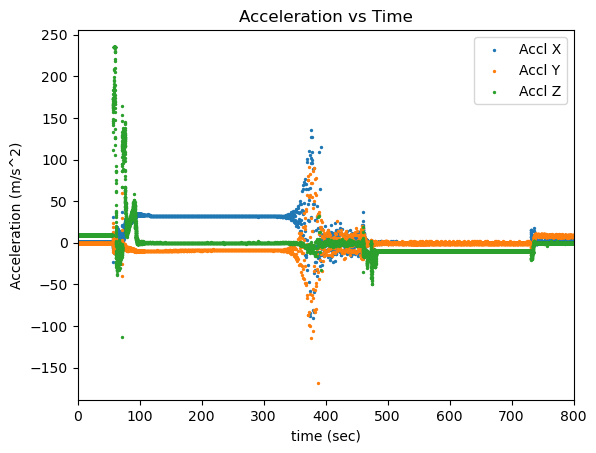

In [21]:
# num = np.linspace(1,len(sensor),len(sensor))

plt.scatter(time, accX, label = 'Accl X', s=2)
plt.scatter(time, accY, label = 'Accl Y', s=2)
plt.scatter(time, accZ, label = 'Accl Z', s=2)
plt.title('Acceleration vs Time')
plt.ylabel('Acceleration (m/s^2)')
plt.xlabel('time (sec)')
plt.xlim(0,800)
#plt.ylim(-50,50)
plt.legend()
plt.show()

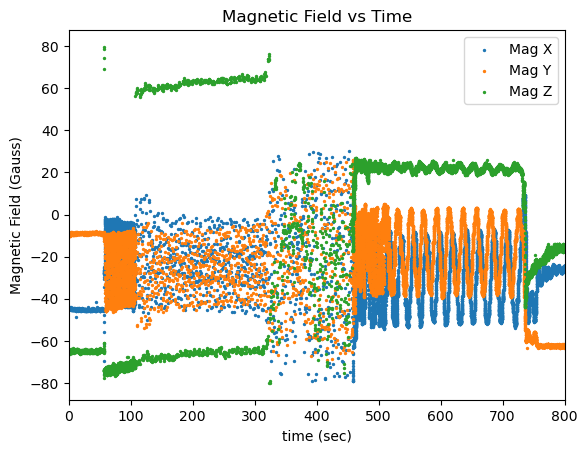

In [24]:
sensor = packets['packets']['Sensor']

magX = []
magY = []
magZ = []

magRawX = []
magRawY = []
magRawZ = []

time = []

for i in range (0, 15000):
    magX.append(sensor[f'{i}']['Magnetic Field'][0])
    magRawX.append(sensor[f'{i}']['Magnetic Field'][0] * 409.6)
    
    magY.append(sensor[f'{i}']['Magnetic Field'][1])
    magRawY.append(sensor[f'{i}']['Magnetic Field'][1] * 409.6)
    
    magZ.append(sensor[f'{i}']['Magnetic Field'][2])
    magRawZ.append(sensor[f'{i}']['Magnetic Field'][2] * 409.6)
    
    
    time.append(sensor[f'{i}']['Start'] / 1000)
    

plt.scatter(time, magX, label = 'Mag X', s=2)
plt.scatter(time, magY, label = 'Mag Y', s=2)
plt.scatter(time, magZ, label = 'Mag Z', s=2)
plt.title('Magnetic Field vs Time')
plt.ylabel('Magnetic Field (Gauss)')
plt.xlabel('time (sec)')
plt.xlim(0,800)
plt.legend()
plt.show()

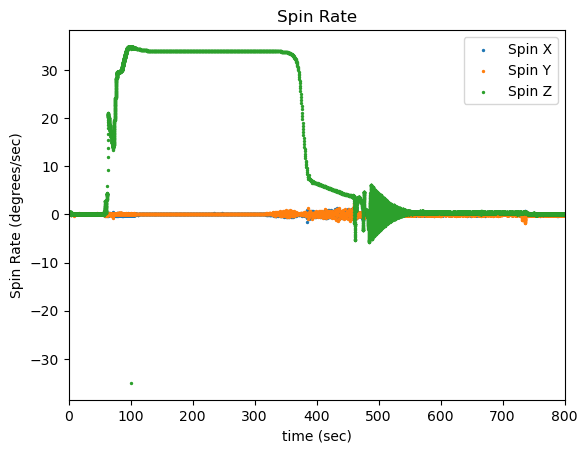

In [28]:
sensor = packets['packets']['Sensor']

spinX = []
spinY = []
spinZ = []

spinXRaw = []
spinYRaw = []
spinZRaw = []

time = []

for i in range (0, 15000):
    spinX.append(sensor[f'{i}']['Spin Rate'][0])
    spinXRaw.append(sensor[f'{i}']['Spin Rate'][0] * 936.25)
    
    spinY.append(sensor[f'{i}']['Spin Rate'][1])
    spinYRaw.append(sensor[f'{i}']['Spin Rate'][1] * 936.25)
    
    spinZ.append(sensor[f'{i}']['Spin Rate'][2])
    spinZRaw.append(sensor[f'{i}']['Spin Rate'][2] * 936.25)
    
    time.append(sensor[f'{i}']['Start'] / 1000)


plt.scatter(time, spinX, label = 'Spin X', s=2)
plt.scatter(time, spinY, label = 'Spin Y', s=2)
plt.scatter(time, spinZ, label = 'Spin Z', s=2)
plt.title('Spin Rate')
plt.ylabel('Spin Rate (degrees/sec)')
plt.xlabel('time (sec)')
plt.xlim(0,800)
plt.legend()
plt.show()

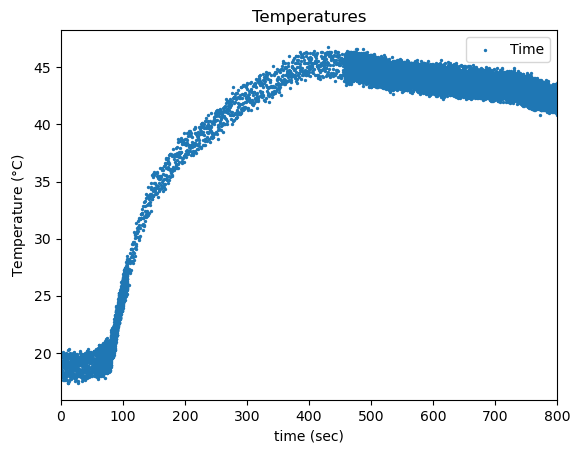

In [32]:
sensor = packets['packets']['Sensor']

temps = []

time = []

for i in range (0, 15000):
    temps.append(sensor[f'{i}']['Temperature'][0])
    
    time.append(sensor[f'{i}']['Start'] / 1000)
    

plt.scatter(time, temps, label = 'Time', s=2)
plt.title('Temperatures')
plt.ylabel('Temperature ($\degree$C)')
plt.xlabel('time (sec)')
plt.xlim(0,800)
plt.legend()
plt.show()


## Voltage Sweeps

In [16]:
FullSweeps = packets['packets']['Full']
DenseSweeps = packets['packets']['Dense']

timeFull = []
timeDens = []

for i in range(0, len(FullSweeps)):
    timeFull.append(FullSweeps[f'{i}']['Start'] / 1000)
    
for i in range(1, len(DenseSweeps)):
    timeDens.append(DenseSweeps[f'{i}']['Start'] / 1000)

print(f'There are {len(FullSweeps)} Full sweeps.')
print(f'They start at {min(timeFull)} seconds and end at {max(timeFull)} seconds.')
print()
print(f'There are {len(DenseSweeps)} Dense sweeps.')
print(f'They start at {min(timeDens)} seconds and end at {max(timeDens)} seconds.')

There are 903 Full sweeps.
They start at 107.677 seconds and end at 459.514 seconds.

There are 101 Dense sweeps.
They start at 111.216 seconds and end at 458.464 seconds.


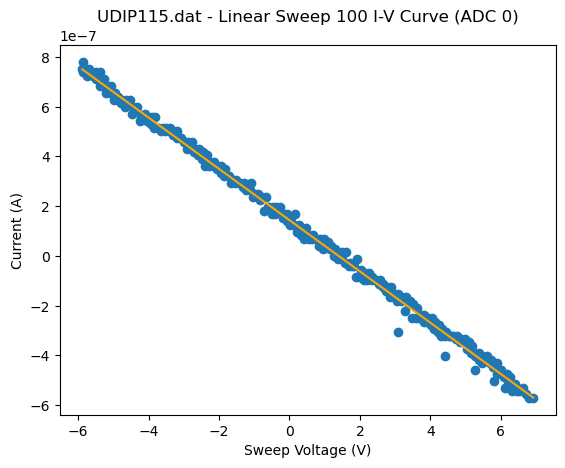

ADC_0 Slope = -1.0316e-07
ADC_0 Standard Error = 3.9982e-10


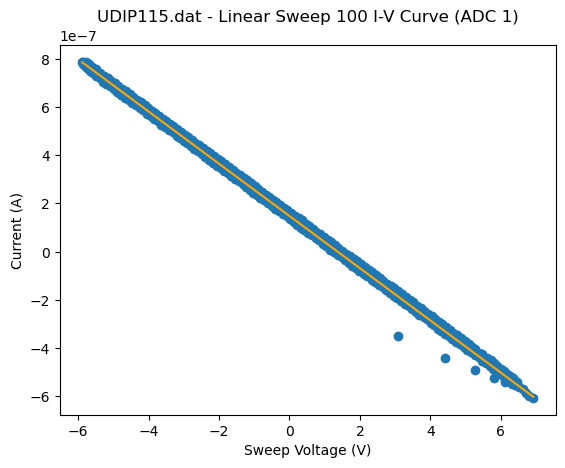

ADC_1 Slope = -1.0829e-07
ADC_1 Standard Error = 4.1239e-10


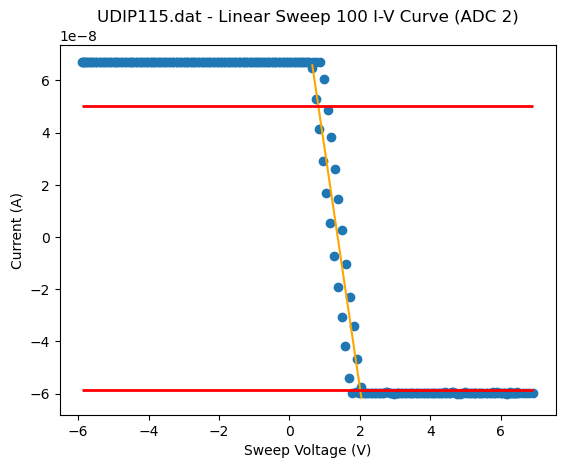

ADC_2 Slope = -9.1490e-08
ADC_2 Standard Error = 9.3155e-09


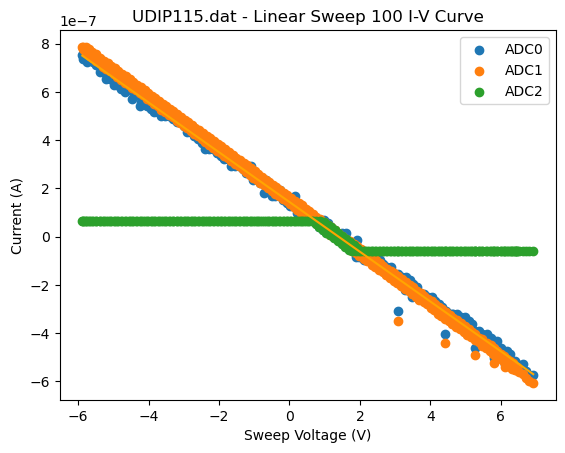

ADC_0 Slope = -1.0316e-07
ADC_1 Slope = -1.0829e-07
ADC_2 Slope = -9.1490e-08

ADC_0 Standard Error = 3.9982e-10
ADC_1 Standard Error = 4.1239e-10
ADC_2 Standard Error = 9.3155e-09


In [7]:
sweepNum = 100
V = packets['packets']['Full'][f'{sweepNum}']['Voltage']
I0 = packets['packets']['Full'][f'{sweepNum}']['Current0']
I1 = packets['packets']['Full'][f'{sweepNum}']['Current1']
I2 = packets['packets']['Full'][f'{sweepNum}']['Current2']

# num = np.linspace(1,len(I2),len(I2))
# plt.scatter(num,I2)
# plt.title(f'{sourceName} - Linear Sweep {sweepNum} - ADC 2 Values in order')
# plt.show()

# num = np.linspace(1,len(V),len(V))
# plt.scatter(num,V)
# plt.title(f'{sourceName} - Linear Sweep {sweepNum} - Voltage Values in order')
# plt.show()

plt.scatter(V[1:],I0[1:])
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 0)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_0 = "{:.4e}".format(popt[0])
std_err_0 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_0 Standard Error = {std_err_0}')

plt.scatter(V[1:],I1[1:])
x, y, popt, pcov = slope_fit(V, I1, 1) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 1)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_1 = "{:.4e}".format(popt[0])
std_err_1 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_1 Standard Error = {std_err_1}')

plt.scatter(V[1:],I2[1:])
x, y, popt, pcov = slope_fit(V, I2, 2) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.hlines(y=adc2_max, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.hlines(y=adc2_min, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 2)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_2 = "{:.4e}".format(popt[0])
std_err_2 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_2 Slope = {slope_2}')
print(f'ADC_2 Standard Error = {std_err_2}')


plt.scatter(V[1:],I0[1:], label = "ADC0")
plt.scatter(V[1:],I1[1:], label = "ADC1")
plt.scatter(V[1:],I2[1:], label = "ADC2")
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_2 Slope = {slope_2}')
print()
print(f'ADC_0 Standard Error = {std_err_0}')
print(f'ADC_1 Standard Error = {std_err_1}')
print(f'ADC_2 Standard Error = {std_err_2}')

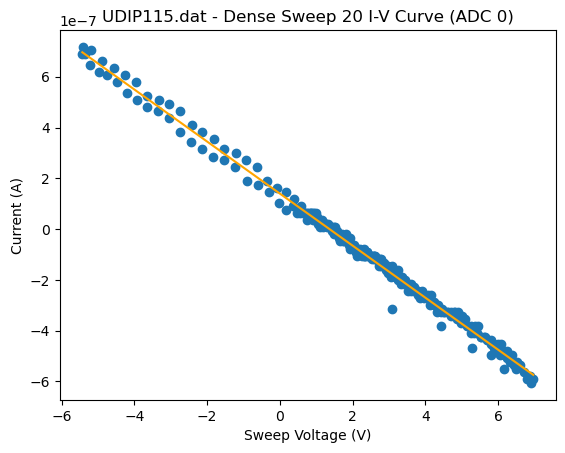

ADC_0 Slope = -1.0247e-07
ADC_0 Standard Error = 5.3278e-10


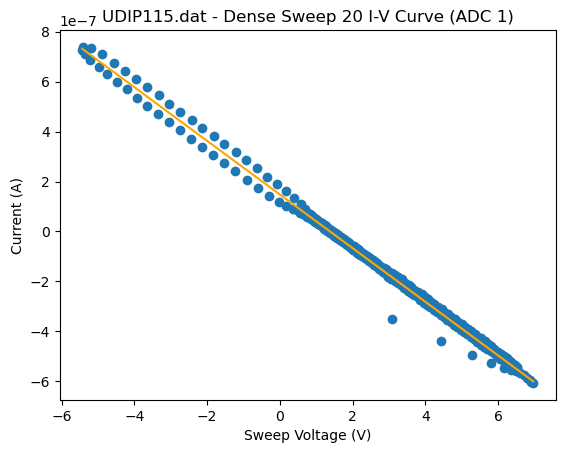

ADC_1 Slope = -1.0746e-07
ADC_1 Standard Error = 5.8075e-10


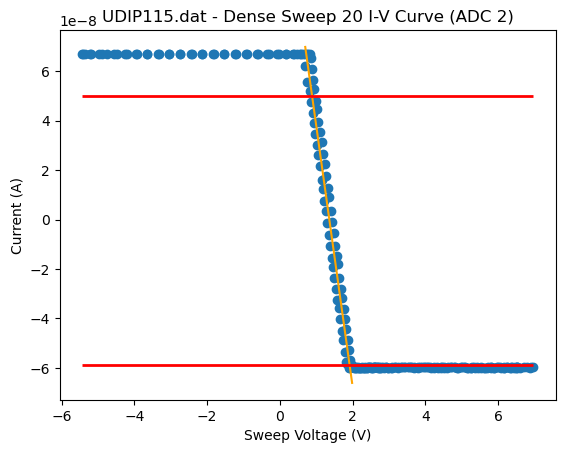

ADC_2 Slope = -1.0549e-07
ADC_2 Standard Error = 2.8511e-09


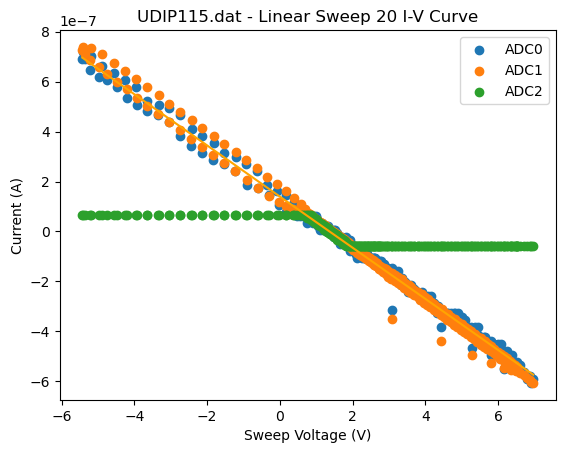

ADC_0 Slope = -1.0247e-07
ADC_1 Slope = -1.0746e-07
ADC_2 Slope = -1.0549e-07

ADC_0 Standard Error = 5.3278e-10
ADC_1 Standard Error = 5.8075e-10
ADC_2 Standard Error = 2.8511e-09


In [7]:
sweepNum = 20
V = packets['packets']['Dense'][f'{sweepNum}']['Voltage']
I0 = packets['packets']['Dense'][f'{sweepNum}']['Current0']
I1 = packets['packets']['Dense'][f'{sweepNum}']['Current1']
I2 = packets['packets']['Dense'][f'{sweepNum}']['Current2']

# num = np.linspace(1,len(I0),len(I0))
# plt.scatter(num,I0)
# plt.title(f'{sourceName} - Dense Sweep {sweepNum} - ADC 0 Values in order')
# plt.show()

plt.scatter(V[1:],I0[1:])
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 0)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_0 = "{:.4e}".format(popt[0])
std_err_0 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_0 Standard Error = {std_err_0}')

plt.scatter(V[1:],I1[1:])
x, y, popt, pcov = slope_fit(V, I1, 1) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 1)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_1 = "{:.4e}".format(popt[0])
std_err_1 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_1 Standard Error = {std_err_1}')

plt.scatter(V[1:],I2[1:])
x, y, popt, pcov = slope_fit(V, I2, 2) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.hlines(y=adc2_max, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.hlines(y=adc2_min, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 2)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_2 = "{:.4e}".format(popt[0])
std_err_2 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_2 Slope = {slope_2}')
print(f'ADC_2 Standard Error = {std_err_2}')


plt.scatter(V[1:],I0[1:], label = "ADC0")
plt.scatter(V[1:],I1[1:], label = "ADC1")
plt.scatter(V[1:],I2[1:], label = "ADC2")
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_2 Slope = {slope_2}')
print()
print(f'ADC_0 Standard Error = {std_err_0}')
print(f'ADC_1 Standard Error = {std_err_1}')
print(f'ADC_2 Standard Error = {std_err_2}')
